In [1]:
#Airbnb is an online marketplace for arranging or offering lodging, 
#primarily homestays, or tourism experiences since 2008. 
#Tourism in Euskadi has been increasing for the las 4 to 5 years, become a popular destination in Europe. 
#Airbnb Euskadi 2020 data contains listing activity and metrics. 
#In this kernel, I provide a simple exploratory analysis of the data, and a first attempt to predict prices with the available data.

#Outline
#1. Import libraries
#2. Loading datasets
#3. Data visualization
#4. Regression analysis 

In [2]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')
from scipy.stats import norm
import urllib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [3]:
#Loading datasets
airbnb=pd.read_csv('/Users/stefaninovoa/Dropbox/Udacity/Project_1/DATA/euskadi_listings_clean.csv', engine='python',na_values=['.'])
#airbnb=pd.read_csv('../euskadi_listings_clean.csv', engine='python')


In [4]:
#Check for Nans
airbnb.isnull().sum()

ID                        0
neighbourhood             0
province                  0
city                      5
zipcode                 160
market                    4
smart_location            0
latitude                  0
longitude                 0
property_type             0
room_type                 0
accommodates              0
bathrooms                11
bedrooms                 15
beds                     25
bed_type                  0
square_feet            5444
price                     0
weekly_price           5220
monthly_price          5308
security_deposit       1820
cleaning_fee           1592
guests_included           0
extra_people              0
minimum_nights            0
maximum_nights            0
availability_30           0
availability_60           0
availability_90           0
availability_365          0
number_of_reviews         0
review_scores_value    1008
cancellation_policy       0
dtype: int64

In [5]:
#Check for duplicates
airbnb.duplicated().sum()


0

In [6]:
#Check for types of variables
airbnb.dtypes

ID                       int64
neighbourhood           object
province                object
city                    object
zipcode                float64
market                  object
smart_location          object
latitude               float64
longitude              float64
property_type           object
room_type               object
accommodates             int64
bathrooms              float64
bedrooms               float64
beds                   float64
bed_type                object
square_feet            float64
price                    int64
weekly_price           float64
monthly_price          float64
security_deposit       float64
cleaning_fee           float64
guests_included          int64
extra_people             int64
minimum_nights           int64
maximum_nights           int64
availability_30          int64
availability_60          int64
availability_90          int64
availability_365         int64
number_of_reviews        int64
review_scores_value    float64
cancella

In [7]:
#drop variables with too many nans
airbnb.drop(['square_feet','weekly_price','monthly_price', 'security_deposit', 'cleaning_fee','neighbourhood'],axis=1,inplace=True)

In [8]:
#fill mean of column for variables with fewer nans
num_vars = airbnb.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    airbnb[col].fillna((airbnb[col].mean()), inplace=True)
airbnb.isnull().sum()

ID                     0
province               0
city                   5
zipcode                0
market                 4
smart_location         0
latitude               0
longitude              0
property_type          0
room_type              0
accommodates           0
bathrooms              0
bedrooms               0
beds                   0
bed_type               0
price                  0
guests_included        0
extra_people           0
minimum_nights         0
maximum_nights         0
availability_30        0
availability_60        0
availability_90        0
availability_365       0
number_of_reviews      0
review_scores_value    0
cancellation_policy    0
dtype: int64

In [9]:
#make sure there are no nans left by dropping nans
airbnb.dropna(how='any',inplace=True)


In [10]:
airbnb.isnull().sum()

ID                     0
province               0
city                   0
zipcode                0
market                 0
smart_location         0
latitude               0
longitude              0
property_type          0
room_type              0
accommodates           0
bathrooms              0
bedrooms               0
beds                   0
bed_type               0
price                  0
guests_included        0
extra_people           0
minimum_nights         0
maximum_nights         0
availability_30        0
availability_60        0
availability_90        0
availability_365       0
number_of_reviews      0
review_scores_value    0
cancellation_policy    0
dtype: int64

In [11]:
#Data Visualization - We are only going to use data within the 5% and 95% quantiles

#Calculate quantiles: 0.95 and 0.5.
quantile95=airbnb.price.quantile(0.95)
quantile5=airbnb.price.quantile(0.05)
#Use only price values in quantile range
airbnb_quantiles=airbnb[(airbnb.price >= quantile5) & (airbnb.price <= quantile95)]
print('max',airbnb_quantiles.price.max())
print('min',airbnb_quantiles.price.min())

max 399
min 25


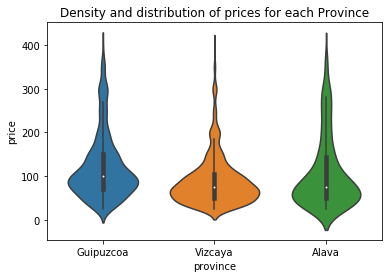

In [12]:
#Density and distribution of prices for each Province(violin plot)
Violin_plot=sns.violinplot(data=airbnb_quantiles, x='province', y='price')
Violin_plot.set_title('Density and distribution of prices for each Province');

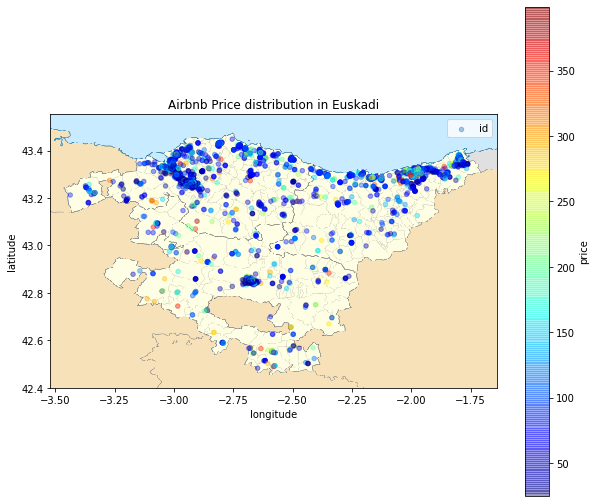

In [13]:
#Price Scatter map for Euskadi

#initializing the figure size
plt.figure(figsize=(10,9))
#loading the png Euskadi image found on Wikicommons and saving to my local folder along with the project
i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/thumb/0/07/Basque_Country_location_map.svg/500px-Basque_Country_location_map.svg.png')
euskadi=plt.imread(i)
plt.imshow(euskadi,zorder=0,extent=[-3.52, -1.64, 42.4,43.552])
ax=plt.gca()
airbnb_quantiles.plot(kind='scatter', x='longitude', y='latitude', label='id', c='price', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.title('Airbnb Price distribution in Euskadi')
plt.show()



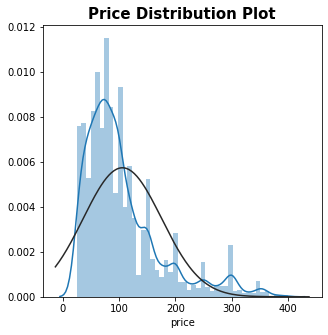

In [14]:
#Price distribution plot
plt.figure(figsize=(5,5))
sns.distplot(airbnb_quantiles['price'],fit=norm)
plt.title("Price Distribution Plot",size=15, weight='bold');

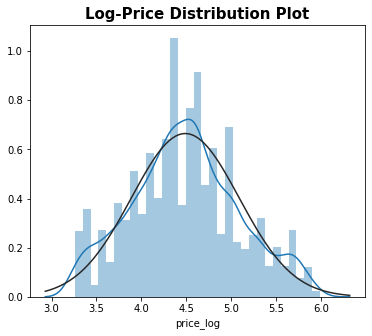

In [15]:
#logarithmic plot
airbnb_quantiles['price_log'] = np.log(airbnb_quantiles.price+1)
plt.figure(figsize=(6,5))
sns.distplot(airbnb_quantiles['price_log'],fit=norm)
plt.title("Log-Price Distribution Plot",size=15, weight='bold');

In [16]:
#airbnb_quantiles.drop(['price_log'], axis=1,inplace=True)


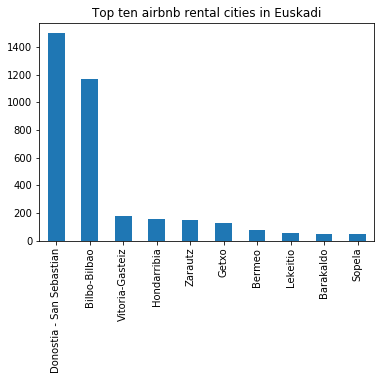

In [17]:
top_10_cities=airbnb_quantiles.city.value_counts(sort=True)
top_10_cities=top_10_cities.head(10).plot(kind='bar',title='Top ten airbnb rental cities in Euskadi')


In [18]:
cat_airbnb = airbnb_quantiles.select_dtypes(include=['object'])
cat_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4984 entries, 0 to 5484
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   province             4984 non-null   object
 1   city                 4984 non-null   object
 2   market               4984 non-null   object
 3   smart_location       4984 non-null   object
 4   property_type        4984 non-null   object
 5   room_type            4984 non-null   object
 6   bed_type             4984 non-null   object
 7   cancellation_policy  4984 non-null   object
dtypes: object(8)
memory usage: 510.4+ KB


In [21]:
##Encode the input Variables
def Encode(airbnb):
    for column in airbnb_quantiles.columns[airbnb_quantiles.columns.isin(['neighbourhood_cleansed','province','city','property_type','room_type','bed_type','cancellation_policy'])]:
        airbnb_quantiles[column] = airbnb_quantiles[column].factorize()[0]
    return airbnb

airbnb_en = Encode(airbnb_quantiles.copy())

In [22]:
airbnb_en

,ID,province,city,zipcode,market,smart_location,latitude,longitude,property_type,room_type,...,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_value,cancellation_policy,price_log
0,132068,0,0,20002.0,San Sebastian,"San Sebastian, Spain",43.32520,-1.97209,0,0,...,1,63,9,21,31,199,491,9.000000,0,4.382027
1,142760,1,1,48350.0,Bilbao,"Busturia, Spain",43.39062,-2.69470,1,0,...,5,730,30,60,90,327,38,9.000000,1,4.521789
2,223952,1,2,48311.0,Bilbao,"Ibarranguelua, Spain",43.39426,-2.64648,2,0,...,7,760,0,0,0,197,12,9.000000,1,5.017280
3,261929,0,0,20002.0,San Sebastian,"San Sebastian, Spain",43.32147,-1.97785,1,1,...,2,760,25,39,69,252,2,9.000000,2,4.189655
4,263613,0,0,20002.0,San Sebastian,"San Sebastian, Spain",43.32157,-1.97851,1,0,...,5,90,28,58,88,88,24,10.000000,1,5.198497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477,42581492,1,58,48901.0,Bilbao,"Barakaldo, Spain",43.29766,-2.98811,1,0,...,1,1125,30,60,90,365,0,9.278473,1,4.836282
5478,42582747,2,20,1009.0,Other (International),"Vitoria-Gasteiz, Spain",42.85448,-2.68031,1,0,...,2,21,29,59,89,178,0,9.278473,1,4.875197
5481,42589893,0,74,20749.0,San Sebastian,"Guipúzcoa, Spain",43.26052,-2.23746,1,0,...,1,1125,30,60,90,365,0,9.278473,1,5.153292
5482,42601883,1,5,48003.0,Bilbao,"Bilbo, Spain",43.25653,-2.92990,1,1,...,1,1,28,51,81,81,0,9.278473,2,3.828641


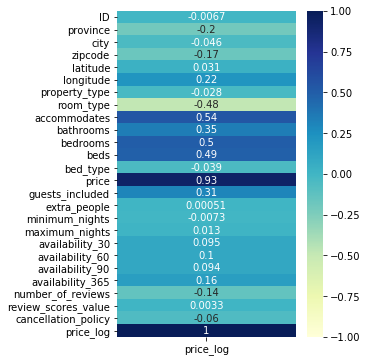

In [23]:
#price correlation with other features
corr = airbnb_en.corr(method='pearson')
plt.figure(figsize=(4,6))
sns.heatmap(corr[['price_log']], annot=True,vmin=-1, vmax=1, cmap="YlGnBu");


In [24]:
#regression model data preparation
#drop columns that are not necessary or the data can be repetitive. For example, city and smart location can be correlated
airbnb_en.drop(['latitude','longitude','city','market',
                    'smart_location','cancellation_policy','price_log'],axis=1, inplace=True)


In [25]:
#response.head()
#cat_airbnb = response.select_dtypes(include=['object'])
#cat_airbnb
airbnb_en.head()

,ID,province,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,...,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_value
0,132068,0,20002.0,0,0,4,1.0,2.0,3.0,0,...,2,20,1,63,9,21,31,199,491,9.0
1,142760,1,48350.0,1,0,2,1.0,1.0,1.0,0,...,1,0,5,730,30,60,90,327,38,9.0
2,223952,1,48311.0,2,0,8,2.0,4.0,9.0,0,...,1,0,7,760,0,0,0,197,12,9.0
3,261929,0,20002.0,1,1,2,1.0,1.0,2.0,0,...,1,20,2,760,25,39,69,252,2,9.0
4,263613,0,20002.0,1,0,5,2.0,2.0,2.0,0,...,5,50,5,90,28,58,88,88,24,10.0


In [26]:
#define fit linear model function

def clean_fit_linear_mod(df, response_col, test_size=.3, rand_state=42):

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]
   

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
  

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test,

In [27]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, = clean_fit_linear_mod(airbnb_en,'price')


In [28]:
print(train_score)
print(test_score)
print(X_train.shape[1]) #Number of columns



0.3714420173561007
0.33041381098445155
20


In [29]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
4,room_type,-2.188631e+01,2.188631e+01
6,bathrooms,1.441727e+01,1.441727e+01
1,province,-1.276552e+01,1.276552e+01
5,accommodates,7.362984e+00,7.362984e+00
7,bedrooms,7.358472e+00,7.358472e+00
9,bed_type,3.868275e+00,3.868275e+00
10,guests_included,1.775245e+00,1.775245e+00
19,review_scores_value,-1.500722e+00,1.500722e+00
15,availability_60,1.028989e+00,1.028989e+00
8,beds,-9.493067e-01,9.493067e-01


In [30]:
#Fit model using Statsmodel
X_endog = sm.add_constant(X_test)
#Fit model, improve this model 
model_sm = sm.OLS(y_test,X_endog)

# Fit model to training set
fit_model = model_sm.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     39.87
Date:                Fri, 17 Apr 2020   Prob (F-statistic):          6.03e-123
Time:                        16:58:50   Log-Likelihood:                -8174.3
No. Observations:                1496   AIC:                         1.639e+04
Df Residuals:                    1475   BIC:                         1.650e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  59.0094     19.768      2.985      0.003      20.233      97.786
ID                  -5.369e-08   1.44e-07     -0.373      0.710   -3.36e-07    2.29e-07
province              -17.3565      2.546     -6.817      0.000     -22.351     -12.362
zipcode                -0.0003   9.99e-05     -3.252      0.001      -0.001      -0.000
property_type           0.3448      0.433      0.797      0.426      -0.504       1.193
room_type             -25.6034      3.332     -7.683      0.000     -32.140     -19.066
accommodates            4.4548      1.455      3.061      0.002       1.600       7.310
bathrooms              13.8963      2.657      5.230      0.000       8.685      19.108
bedrooms                2.6188      2.784      0.941      0.347      -2.843       8.080
beds                    3.4138      1.480      2.307      0.021       0.511       6.316
bed_type               -9.6877     12.141     -0.798      0.425     -33.503      14.127
guests_included         3.6262      1.162      3.120      0.002       1.346       5.906
extra_people           -0.1004      0.100     -0.999      0.318      -0.298       0.097
minimum_nights         -0.5702      0.289     -1.971      0.049      -1.138      -0.003
maximum_nights          0.0013      0.003      0.476      0.634      -0.004       0.007
availability_30        -0.8515      0.441     -1.931      0.054      -1.716       0.013
availability_60         1.2035      0.450      2.673      0.008       0.320       2.087
availability_90        -0.5941      0.227     -2.614      0.009      -1.040      -0.148
availability_365        0.0631      0.018      3.540      0.000       0.028       0.098
number_of_reviews      -0.1221      0.027     -4.600      0.000      -0.174      -0.070
review_scores_value     2.0090      2.008      1.001      0.317      -1.930       5.948
==============================================================================
Omnibus:                      437.926   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1368.756
Skew:                           1.460   Prob(JB):                    6.00e-298
Kurtosis:                       6.665   Cond. No.                     3.65e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.65e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""